In [1]:
# magic function, basically reduces the need of calling plt.show()
%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph

In [2]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    yy = yy.astype('float32')
    xx = xx.astype('float32')
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=-y, cmap=plt.cm.Spectral)


# First experiment on the half moon dataset from sklearn

In [ ]:
# Generate a dataset and plot it
num_samples = 300
num_outputs = 2

# noise: Standard deviation of Gaussian noise added to the data
X, y = sklearn.datasets.make_moons(num_samples, noise=0.20)

X_tr = X[:200].astype('float32')
X_val = X[200:250].astype('float32')
X_te = X[250:].astype('float32')

y_tr = y[:200].astype('int32')
y_val = y[200:250].astype('int32')
y_te = y[250:].astype('int32')

# s: marker size, c: color, cmap: colormap for c
plt.scatter(X_tr[:,0], X_tr[:,1], s=40, c=y_tr, cmap=plt.cm.RdYlGn) 

print(X.shape, y.shape)

num_features = X_tr.shape[-1]

In [ ]:
# resets the graph, needed when initializing weights multiple times
reset_default_graph()

x_pl = tf.placeholder(tf.float32, [None, num_features])

# uniform: samples drawn from uniform distribution within [-sqrt(3*scale/n), sqrt(3*scale/n)]
# normal: samples drawn from truncated normal distribution centered on 0, stdded=sqrt(scale/n), where n is related to mode
# c.f. Delving deep into rectifiers: https://arxiv.org/pdf/1502.01852v1.pdf
weight_initializer = tf.variance_scaling_initializer(scale=2.0, mode='fan_in', distribution='normal')
with tf.variable_scope('l_1', reuse = tf.AUTO_REUSE): # if you run it more than once, reuse has to be True
    W_1 = tf.get_variable('W', [num_features, 100],
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [100],
                          initializer=tf.constant_initializer(0.0))
with tf. variable_scope('l_2', reuse = tf.AUTO_REUSE):
    W_2 = tf.get_variable('W', [100, num_output],
                          initializer=weight_initializer)
    b_2 = tf.get_variable('b', [num_output],
                          initializer=tf.constant_initializer(0.0))

l_1 = tf.nn.xw_plus_b(x_pl, W_1, b_1)
l_1_nonlinear = tf.nn.relu(l_1)
l_2 = tf.nn.xw_plus_b(l_1_nonlinear, W_2, b_2)
# Note: the layer before the softmax should not have a nonlinearity

In [ ]:
# To get some info about our tensors and ops
print(W_1.name)
print(W_1.get_shape())
print(W_1)

In [ ]:
y_ = tf.placeholder(tf.float32, [None, num_output])

# We don't use the following since it can run into numerical instabilities
# cross_entropy = -tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])
# cross_entropy = tf.reduce_mean(cross_entropy)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=l_2))

# ADAM: https://arxiv.org/pdf/1412.6980.pdf
# Default values:
# learning_rate=0.001,
# beta1=0.9,
# beta2=0.999,
# epsilon=1e-08, to prevent numerical unstability
train_op = tf.train.AdamOptimizer().minimize(cross_entropy)


In [ ]:
correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
def pred(X_in, sess):
    feed_dict = {x_pl: X_in}
    fetches = [l_2]
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

num_epochs = 1000

train_cost, val_cost, val_acc = [],[],[]
# Optional: restrict memory usage, TensorFlow will use all memory otherwise
# gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
with tf.Session(#config=tf.ConfigProto(gpu_options=gpu_opts)
                ) as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    plot_decision_boundary(lambda x: pred(x, sess), X_val, y_val)
    plt.title("Untrained Classifier")
    for e in range(num_epochs):
        ### TRAINING ###
        # default axis for one_hot is -1, returns len(y_tr) x depth tensor
        feed_dict_train = {x_pl: X_tr, y_: tf.one_hot(y_tr, depth=num_outputs).eval()} 
        
        # deciding which parts to fetch, train_op makes the classifier "train"
        fetches_train = [train_op, cross_entropy]
        
        res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        # storing cross entropy (second fetch argument, so index=1)
        train_cost += [res[1]]
    
        ### VALIDATING ###
        feed_dict_valid = {x_pl: X_val, y_: tf.one_hot(y_val, depth=num_outputs).eval()}

        # deciding which parts to fetch
        fetches_valid = [cross_entropy, accuracy]

        # Validation
        res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
        val_cost += [res[0]]
        val_acc += [res[1]]

        if e % 100 == 0:
            print("Epoch {:.0f}, Train Cost: {:.4f}\tVal Cost: {:.4f}\t Val acc: {:.4f}".format((e,
                                                                                               train_cost[-1],
                                                                                               val_cost[-1],
                                                                                               val_acc[-1]))

    ### TESTING ###
    feed_dict_test = {x_pl: X_te, y_: tf.one_hot(y_te, depth=num_outputs).eval()}

    # deciding which parts to fetch
    fetches_test = [cross_entropy, accuracy]

    # Validation
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    test_cost = res[0]
    test_acc = res[1]
    print('\nTest Cost: {:.4f}\tTest Accuracy: {:.4f}'.format(test_cost, test_acc))
    
    plot_decision_boundary(lambda x: pred(x, sess), X_te, y_te)

# Note: Don't need to use the session environment anymore, so returning from it
plt.title("Trained Classifier")

epoch = np.arange(len(train_cost))
plt.figure()
plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

# We now attempt to tackle MNIST dataset

In [3]:
data = np.load('mnist.npz')
num_classes = 10
x_train = data['X_train'][:2000].astype('float32')
targets_train = data['y_train'][:2000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
targets_test = data['y_test'][:500].astype('int32')


Text(0.5, 1.0, 'MNIST handwritten digits')

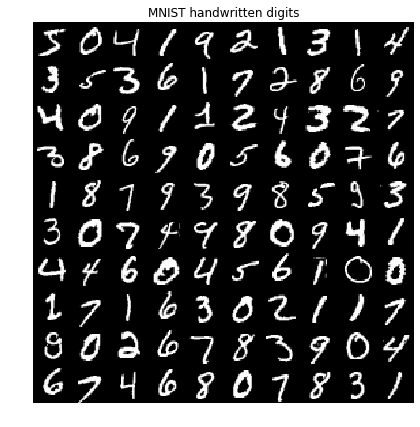

In [4]:
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')

In [5]:
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

reset_default_graph()

x_pl = tf.placeholder(tf.float32, [None, num_features])

weight_initializer = tf.variance_scaling_initializer(scale=2.0, mode='fan_in', distribution='normal')

with tf.variable_scope('l_1', reuse=tf.AUTO_REUSE):
    W_1 = tf.get_variable('W', [num_features, num_l1],
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [num_l1],
                          initializer=tf.constant_initializer(0.0))

with tf.variable_scope('l_2', reuse=tf.AUTO_REUSE):
    W_2 = tf.get_variable('W', [num_l1, num_classes],
                          initializer=weight_initializer)
    b_2 = tf.get_variable('b', [num_classes],
                          initializer=tf.constant_initializer(0.0))

l_1 = tf.nn.xw_plus_b(x_pl, W_1, b_1)
l_1_nonlinear = tf.nn.relu(l_1)
l_2 = tf.nn.xw_plus_b(l_1_nonlinear, W_2, b_2)

In [6]:
y_ = tf.placeholder(tf.float32, [None, num_classes])

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=l_2))

# L2 regularization
regularize = tf.contrib.layers.l2_regularizer(0.0001)
params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
reg_term = sum([regularize(param) for param in params])
cross_entropy += reg_term

train_op = tf.train.AdamOptimizer().minimize(cross_entropy)


Epoch 1 : Train Loss 0.1596 , Train acc 0.8500,  Valid acc 0.7943 
Epoch 2 : Train Loss 0.0632 , Train acc 0.8943,  Valid acc 0.8411 
Epoch 3 : Train Loss 0.0455 , Train acc 0.9245,  Valid acc 0.8568 
Epoch 4 : Train Loss 0.0369 , Train acc 0.9406,  Valid acc 0.8646 
Epoch 5 : Train Loss 0.0303 , Train acc 0.9557,  Valid acc 0.8698 
Epoch 6 : Train Loss 0.0257 , Train acc 0.9667,  Valid acc 0.8698 
Epoch 7 : Train Loss 0.0219 , Train acc 0.9755,  Valid acc 0.8750 
Epoch 8 : Train Loss 0.0187 , Train acc 0.9818,  Valid acc 0.8776 
Epoch 9 : Train Loss 0.0161 , Train acc 0.9859,  Valid acc 0.8854 
Epoch 10 : Train Loss 0.0142 , Train acc 0.9896,  Valid acc 0.8828 
Epoch 11 : Train Loss 0.0127 , Train acc 0.9922,  Valid acc 0.8828 
Epoch 12 : Train Loss 0.0114 , Train acc 0.9953,  Valid acc 0.8828 
Epoch 13 : Train Loss 0.0102 , Train acc 0.9984,  Valid acc 0.8880 
Epoch 14 : Train Loss 0.0092 , Train acc 0.9990,  Valid acc 0.8906 
Epoch 15 : Train Loss 0.0085 , Train acc 0.9990,  Valid a

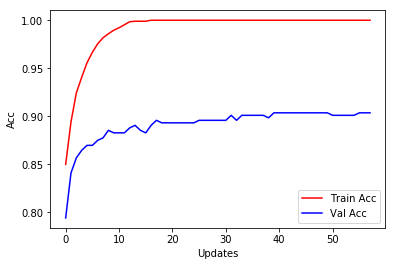

In [7]:
from confusionmatrix import ConfusionMatrix

batch_size = 128
num_epochs = 500
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []

try:
    with tf.Session(#config=tf.ConfigProto(gpu_options=gpu_opts)
                    ) as sess:

        init = tf.global_variables_initializer()
        sess.run(init)
        ## TRAINING ##
        for epoch in range(num_epochs):
            #Forward->Backprob->Update params
            cur_loss = 0
            for i in range(num_batches_train):
                idx = range(i*batch_size, (i+1)*batch_size)
                x_batch = x_train[idx]
                target_batch = targets_train[idx]
                feed_dict_train = {x_pl: x_batch, y_: tf.one_hot(target_batch, depth=num_classes).eval()}
                fetches_train = [train_op, cross_entropy]
                res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
                batch_loss = res[1]
                cur_loss += batch_loss
            loss += [cur_loss/batch_size]

            confusion_valid = ConfusionMatrix(num_classes)
            confusion_train = ConfusionMatrix(num_classes)

            ### EVAL - TRAIN ###
            for i in range(num_batches_train):
                idx = range(i*batch_size, (i+1)*batch_size)
                x_batch = x_train[idx]
                targets_batch = targets_train[idx]
                feed_dict_eval_train = {x_pl: x_batch, y_: tf.one_hot(targets_batch, depth=num_classes).eval()}
                # deciding which parts to fetch
                fetches_eval_train = [l_2]
                # running the validation
                res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
                net_out = res[0]
                preds = np.argmax(net_out, axis=-1)
                confusion_train.batch_add(targets_batch, preds)

            ### EVAL - VALIDATION ###
            confusion_valid = ConfusionMatrix(num_classes)
            for i in range(num_batches_valid):
                idx = range(i*batch_size, (i+1)*batch_size)
                x_batch = x_valid[idx]
                targets_batch = targets_valid[idx]
                feed_dict_eval_train = {x_pl: x_batch, y_: tf.one_hot(targets_batch, depth=num_classes).eval()}
                # deciding which parts to fetch
                fetches_eval_train = [l_2]
                res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
                net_out = res[0]
                preds = np.argmax(net_out, axis=-1) 
                confusion_valid.batch_add(targets_batch, preds)

            train_acc_cur = confusion_train.accuracy()
            valid_acc_cur = confusion_valid.accuracy()

            train_acc += [train_acc_cur]
            valid_acc += [valid_acc_cur]
            print("Epoch {:.0f} : Train Loss {:.4f} , Train acc {:.4f},  Valid acc {:.4f} "\
            .format(epoch+1, loss[-1], train_acc_cur, valid_acc_cur))
        
except KeyboardInterrupt: 
    epoch = np.arange(len(train_acc))
    plt.figure()
    plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
    plt.legend(['Train Acc','Val Acc'])
    plt.xlabel('Updates'), plt.ylabel('Acc')